In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from collections import Counter
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configuration des graphiques
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 10

In [5]:
try:
    # Charger le fichier complet en DataFrame
    df_full = pd.read_csv('archive/US_Accidents_March23.csv')
    print(f"✅ Fichier US_Accidents_March23.csv chargé avec succès!")
    print(f"   📊 Dimensions totales: {df_full.shape[0]:,} lignes × {df_full.shape[1]} colonnes")
    print(f"   💾 Taille mémoire: {df_full.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
except FileNotFoundError:
    print("❌ Erreur: Le fichier 'US_Accidents_March23.csv' n'a pas été trouvé!")
    print("   Veuillez vérifier que le fichier existe dans le répertoire de travail.")
    raise

✅ Fichier US_Accidents_March23.csv chargé avec succès!
   📊 Dimensions totales: 7,728,394 lignes × 46 colonnes
   💾 Taille mémoire: 10870.28 MB


In [7]:
# Définir le nombre de lignes à extraire
n_rows = 300000

In [9]:
if len(df_full) >= n_rows:
    df_300k = df_full.head(n_rows).copy()
    print(f"\n✅ Extraction réussie de {n_rows:,} lignes ({(n_rows/len(df_full)*100):.1f}% du total)")
else:
    df_300k = df_full.copy()
    print(f"\n⚠️  Le fichier contient seulement {len(df_full):,} lignes")
    print(f"   Toutes les lignes seront utilisées")
    n_rows = len(df_full)

print(f"📊 Dimensions extraites: {df_300k.shape[0]:,} lignes × {df_300k.shape[1]} colonnes")


✅ Extraction réussie de 300,000 lignes (3.9% du total)
📊 Dimensions extraites: 300,000 lignes × 46 colonnes


In [11]:
if 'Severity' in df_300k.columns:
    print("\n   Vérification correcte de la distribution de Severity:")

    full_dist = df_full['Severity'].value_counts(normalize=True).sort_index()
    small_dist = df_300k['Severity'].value_counts(normalize=True).sort_index()

    comparison = pd.DataFrame({
        "Full Dataset (%)": (full_dist * 100).round(3),
        "Extracted 300k (%)": (small_dist * 100).round(3),
        "Diff (%)": ((small_dist - full_dist).abs() * 100).round(3)
    })

    print(comparison)

    if (comparison["Diff (%)"] < 1).all():
        print("\n✅ Distribution globalement maintenue (écart < 1%)")
    else:
        print("\n⚠️ La distribution n'est PAS conservée (écart > 1%)")


   Vérification correcte de la distribution de Severity:
          Full Dataset (%)  Extracted 300k (%)  Diff (%)
Severity                                                
1                    0.872               0.075     0.796
2                   79.667              62.711    16.956
3                   16.813              37.159    20.346
4                    2.649               0.055     2.594

⚠️ La distribution n'est PAS conservée (écart > 1%)


In [13]:
# Libérer la mémoire du DataFrame complet
del df_full
import gc
gc.collect()
print("🗑️  Mémoire libérée (DataFrame original supprimé)")

🗑️  Mémoire libérée (DataFrame original supprimé)


In [15]:
df_300k.to_csv('archive/severity.csv', index=False)
print(f"✅ Export réussi!")
print(f"📁 Fichier créé: severity.csv ({n_rows:,} lignes)")
print(f"💾 Taille du fichier: ~{df_300k.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

✅ Export réussi!
📁 Fichier créé: severity.csv (300,000 lignes)
💾 Taille du fichier: ~420.73 MB


In [17]:
df = pd.read_csv('archive/severity.csv')
print(f"✅ Fichier severity.csv chargé avec succès!")
print(f"📊 Dimensions: {df.shape[0]:,} lignes × {df.shape[1]} colonnes")
print(f"💾 Utilisation mémoire: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

✅ Fichier severity.csv chargé avec succès!
📊 Dimensions: 300,000 lignes × 46 colonnes
💾 Utilisation mémoire: 420.73 MB


In [19]:
# Aperçu des premières lignes
print("="*80)
print("APERÇU DES DONNÉES")
print("="*80)
display(df.head(10))

APERÇU DES DONNÉES


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,I-70 E,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,Brice Rd,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,Accident on OH-32 State Route 32 Westbound at ...,State Route 32,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,Accident on I-75 Southbound at Exits 52 52B US...,I-75 S,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,Miamisburg Centerville Rd,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day
5,A-6,Source2,3,2016-02-08 07:44:26,2016-02-08 08:14:26,40.100590,-82.925194,NaN,NaN,0.01,Accident on I-270 Outerbelt Northbound near Ex...,Westerville Rd,Westerville,Franklin,OH,43081,US,US/Eastern,KCMH,2016-02-08 07:51:00,37.9,35.5,97.0,29.63,7.0,SSW,3.5,0.03,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
6,A-7,Source2,2,2016-02-08 07:59:35,2016-02-08 08:29:35,39.758274,-84.230507,NaN,NaN,0.00,Accident on Oakridge Dr at Woodward Ave. Expec...,N Woodward Ave,Dayton,Montgomery,OH,45417-2476,US,US/Eastern,KDAY,2016-02-08 07:56:00,34.0,31.0,100.0,29.66,7.0,WSW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
7,A-8,Source2,3,2016-02-08 07:59:58,2016-02-08 08:29:58,39.770382,-84.194901,NaN,NaN,0.01,Accident on I-75 Southbound at Exit 54B Grand ...,N Main St,Dayton,Montgomery,OH,45405,US,US/Eastern,KDAY,2016-02-08 07:56:00,34.0,31.0,100.0,29.66,7.0,WSW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
8,A-9,Source2,2,2016-02-08 08:00:40,2016-02-08 08:30:40,39.778061,-84.172005,NaN,NaN,0.00,Accident on Notre Dame Ave at Warner Ave. Expe...,Notre Dame Ave,Dayton,Montgomery,OH,45404-1923,US,US/Eastern,KFFO,2016-02-08 07:58:00,33.3,NaN,99.0,29.67,5.0,SW,1.2,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
9,A-10,Source2,3,2016-02-08 08:10:04,2016-02-08 08:40:04,40.100590,-82.925194,NaN,NaN,0.01,Right hand shoulder blocked due to accident on...,Westerville Rd,Westerville,Franklin,OH,43081

In [21]:
# Informations sur le dataset
print("\n" + "="*80)
print("INFORMATIONS SUR LES TYPES DE DONNÉES")
print("="*80)
df.info()


INFORMATIONS SUR LES TYPES DE DONNÉES
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 46 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     300000 non-null  object 
 1   Source                 300000 non-null  object 
 2   Severity               300000 non-null  int64  
 3   Start_Time             300000 non-null  object 
 4   End_Time               300000 non-null  object 
 5   Start_Lat              300000 non-null  float64
 6   Start_Lng              300000 non-null  float64
 7   End_Lat                0 non-null       float64
 8   End_Lng                0 non-null       float64
 9   Distance(mi)           300000 non-null  float64
 10  Description            300000 non-null  object 
 11  Street                 300000 non-null  object 
 12  City                   299984 non-null  object 
 13  County                 300000 non-null  object 
 1

In [23]:
# Statistiques descriptives
print("\n" + "="*80)
print("STATISTIQUES DESCRIPTIVES")
print("="*80)
display(df.describe())


STATISTIQUES DESCRIPTIVES


,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,300000.000000,300000.000000,300000.000000,0.0,0.0,300000.000000,295644.000000,35615.000000,295193.000000,296487.000000,293337.000000,242246.000000,29036.000000
mean,2.371927,35.814760,-97.632531,NaN,NaN,0.049009,65.180581,30.510021,65.150159,30.018196,9.238826,8.515888,0.065433
std,0.486002,4.686140,18.412488,NaN,NaN,0.679245,16.977736,16.856171,21.207637,0.255681,2.109278,5.756141,0.538391
min,1.000000,25.433098,-123.813927,NaN,NaN,0.000000,-77.800000,-29.300000,4.000000,0.120000,0.000000,0.000000,0.000000
25%,2.000000,32.924090,-118.102577,NaN,NaN,0.000000,55.400000,22.200000,50.000000,29.910000,10.000000,5.000000,0.000000
50%,2.000000,34.257259,-95.520012,NaN,NaN,0.000000,66.900000,31.400000,67.000000,30.010000,10.000000,8.100000,0.010000
75%,3.000000,40.064110,-81.494834,NaN,NaN,0.010000,77.000000,38.200000,82.000000,30.120000,10.000000,10.400000,0.030000
max,4.000000,44.895218,-70.571518,NaN,NaN,80.890000,161.600000,111.000000,100.000000,33.040000,105.000000,822.800000,10.140000


In [25]:
# Vérification des valeurs manquantes
print("\n" + "="*80)
print("VALEURS MANQUANTES")
print("="*80)
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Colonnes': missing.index,
    'Valeurs_Manquantes': missing.values,
    'Pourcentage': missing_pct.values
})
missing_df = missing_df[missing_df['Valeurs_Manquantes'] > 0]
if len(missing_df) > 0:
    display(missing_df)
else:
    print("✅ Aucune valeur manquante détectée!")


VALEURS MANQUANTES


,Colonnes,Valeurs_Manquantes,Pourcentage
7,End_Lat,300000,100.000000
8,End_Lng,300000,100.000000
12,City,16,0.005333
15,Zipcode,30,0.010000
17,Timezone,30,0.010000
18,Airport_Code,30,0.010000
19,Weather_Timestamp,2470,0.823333
20,Temperature(F),4356,1.452000
21,Wind_Chill(F),264385,88.128333
22,Humidity(%),4807,1.602333



VALEURS MANQUANTES


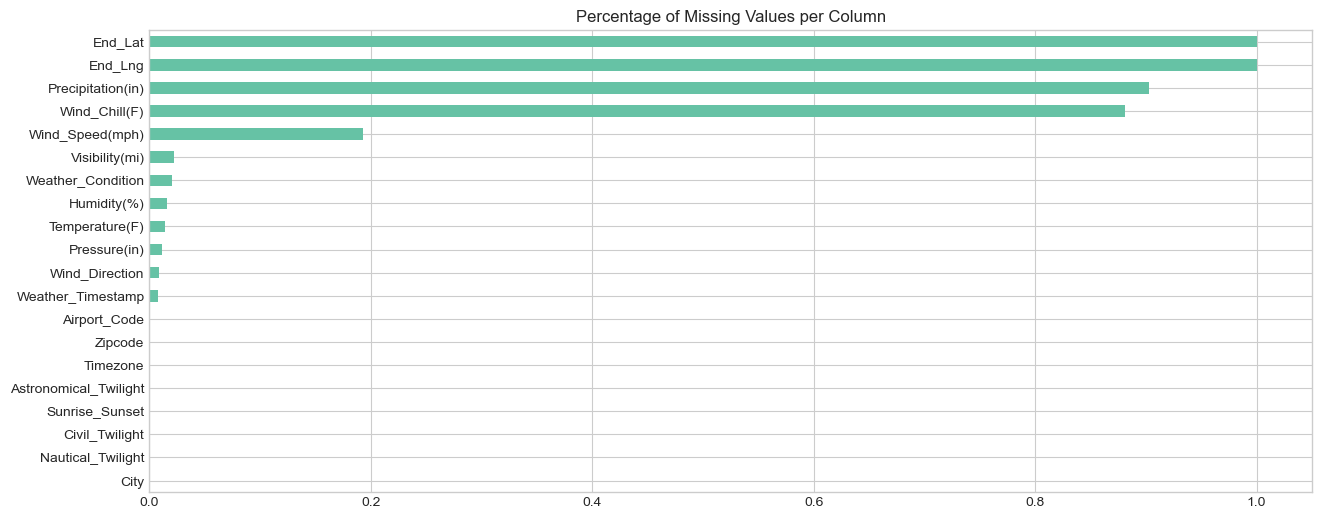

In [27]:
# Vérification des valeurs manquantes
print("\n" + "="*80)
print("VALEURS MANQUANTES")
print("="*80)

missing_pct = df.isnull().sum().sort_values(ascending=False) / df.shape[0]
missing_pct = missing_pct[missing_pct != 0]
plt.figure()
missing_pct.sort_values(ascending=True).plot(kind='barh')
plt.title('Percentage of Missing Values per Column');


DISTRIBUTION DE LA VARIABLE CIBLE (Severity)
Severity 1: 226 (0.08%)
Severity 2: 188,134 (62.71%)
Severity 3: 111,476 (37.16%)
Severity 4: 164 (0.05%)


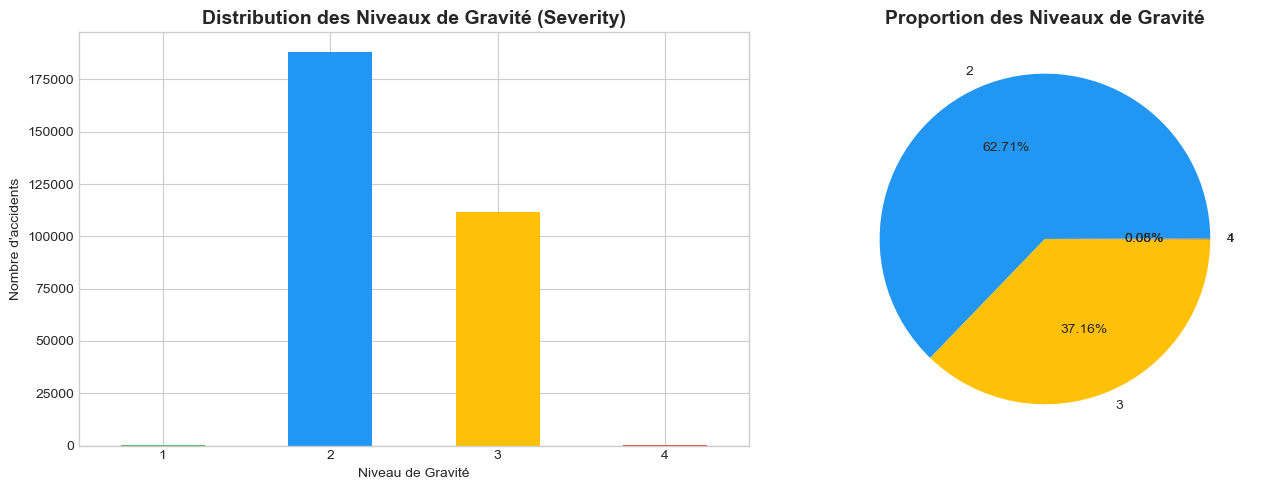

In [29]:
import matplotlib.pyplot as plt

# ============================================================================
# Distribution de la variable cible (Severity)
# ============================================================================
print("\n" + "="*80)
print("DISTRIBUTION DE LA VARIABLE CIBLE (Severity)")
print("="*80)

severity_dist = df['Severity'].value_counts()
severity_pct = df['Severity'].value_counts(normalize=True) * 100

# Affichage des classes de 1 à 4
for cls in sorted(severity_dist.index):
    pct = severity_pct[cls]
    count = severity_dist[cls]
    print(f"Severity {cls}: {count:,} ({pct:.2f}%)")

# ============================================================================
# Visualisation
# ============================================================================
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
severity_dist.sort_index().plot(
    kind='bar',
    ax=ax[0],
    color=['#4CAF50', '#2196F3', '#FFC107', '#F44336']
)
ax[0].set_title('Distribution des Niveaux de Gravité (Severity)', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Niveau de Gravité')
ax[0].set_ylabel('Nombre d\'accidents')
ax[0].set_xticklabels([1, 2, 3, 4], rotation=0)

# Pie chart
severity_dist.sort_index().plot(
    kind='pie',
    ax=ax[1],
    autopct='%1.2f%%',
    colors=['#4CAF50', '#2196F3', '#FFC107', '#F44336']
)
ax[1].set_title('Proportion des Niveaux de Gravité', fontsize=14, fontweight='bold')
ax[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [31]:
print("="*80)
print("NETTOYAGE DES DONNÉES : US ACCIDENTS")
print("="*80)

# =====================
# 0. COPIE DU DATASET
# =====================
df_clean = df.copy()
print("✓ Copie du dataset créée")

# =====================================
# 1. SUPPRESSION DES COLONNES inutiles
# =====================================
drop_cols = [
    "End_Lat",
    "End_Lng",
    "Precipitation(in)",
    "Wind_Chill(F)"
]

df_clean = df_clean.drop(columns=[c for c in drop_cols if c in df_clean.columns])
print("✓ Colonnes supprimées :", [c for c in drop_cols if c in df_clean.columns])

# ===========================================================================
# 2. Remplacer les valeurs manquantes des colonnes catégorielles par le mode
# ===========================================================================

categorical_cols = [ 'City', 'Zipcode',  'Timezone', 'Airport_Code',
    'Wind_Direction', 'Weather_Condition', 'Sunrise_Sunset',
    'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'
]

for col in categorical_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])
    
print("✓ colonnes catégorielles remplacées par le mode")

# ===========================================================================
# 3. Remplacer les valeurs manquantes des colonnes numériques par la médiane
# ===========================================================================

numeric_cols = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)']

for col in numeric_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())
    
print("✓ colonnes numériques remplacées par la médiane")

# ========================
# 4. CORRECTION DES DATES
# ========================

date_cols = ["Start_Time", "End_Time", "Weather_Timestamp"]

for col in date_cols:
    if col in df_clean.columns:
        df_clean[col] = pd.to_datetime(df_clean[col], errors="coerce")

print("✓ Dates converties en datetime")

print(f"\n✓ Dataset nettoyé: {df_clean.shape[0]:,} lignes × {df_clean.shape[1]} colonnes")

NETTOYAGE DES DONNÉES : US ACCIDENTS
✓ Copie du dataset créée
✓ Colonnes supprimées : []
✓ colonnes catégorielles remplacées par le mode
✓ colonnes numériques remplacées par la médiane
✓ Dates converties en datetime

✓ Dataset nettoyé: 300,000 lignes × 42 colonnes


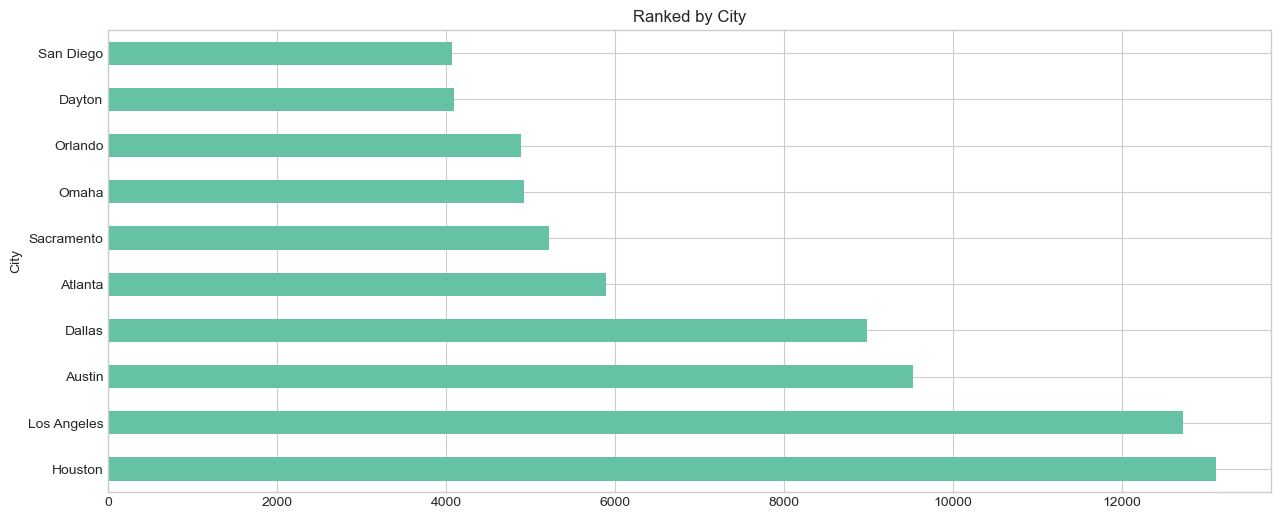

In [33]:
cities_counts = df_clean['City'].value_counts().sort_values(ascending=False)
plt.figure()
cities_counts.sort_values(ascending=False)[:10].plot(kind='barh')
plt.title('Ranked by City');

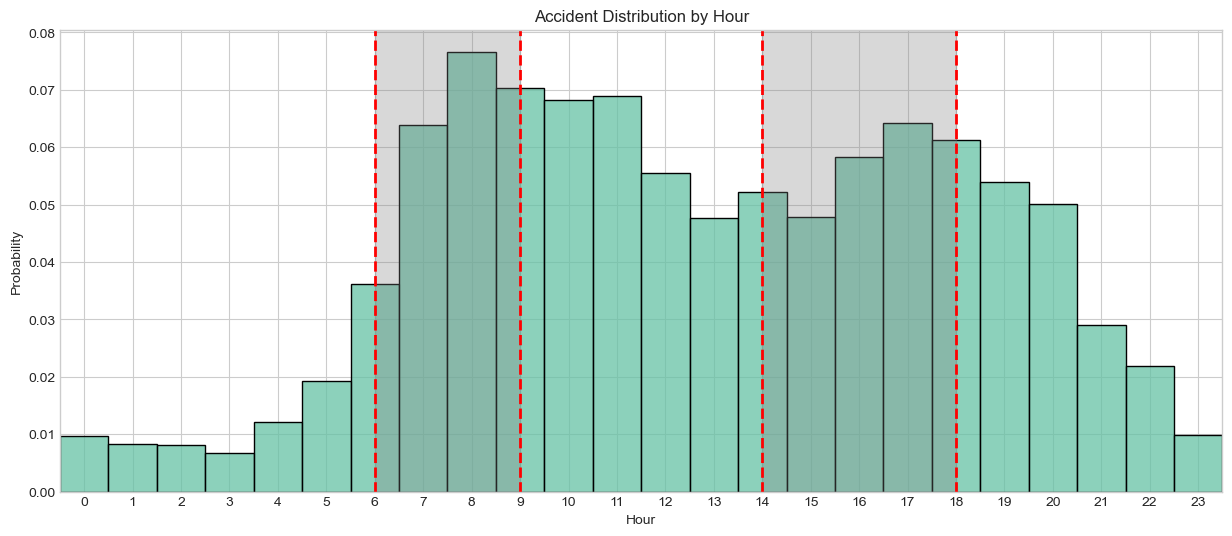

In [35]:
hour_data = df_clean['Start_Time'].dt.hour

sns.histplot(hour_data, bins=24, stat="probability",discrete=True)

start, end = 6, 9
plt.axvline(x=start, color='red', linestyle='--', linewidth=2)
plt.axvline(x=end, color='red', linestyle='--', linewidth=2)
plt.axvspan(start, end, color='gray', alpha=0.3)

start2, end2 = 14, 18
plt.axvline(x=start2, color='red', linestyle='--', linewidth=2)
plt.axvline(x=end2, color='red', linestyle='--', linewidth=2)
plt.axvspan(start2, end2, color='gray', alpha=0.3)

plt.xlim(-0.5, 23.5)
plt.xticks(range(24))
plt.xlabel('Hour')
plt.ylabel('Probability')
plt.title('Accident Distribution by Hour');

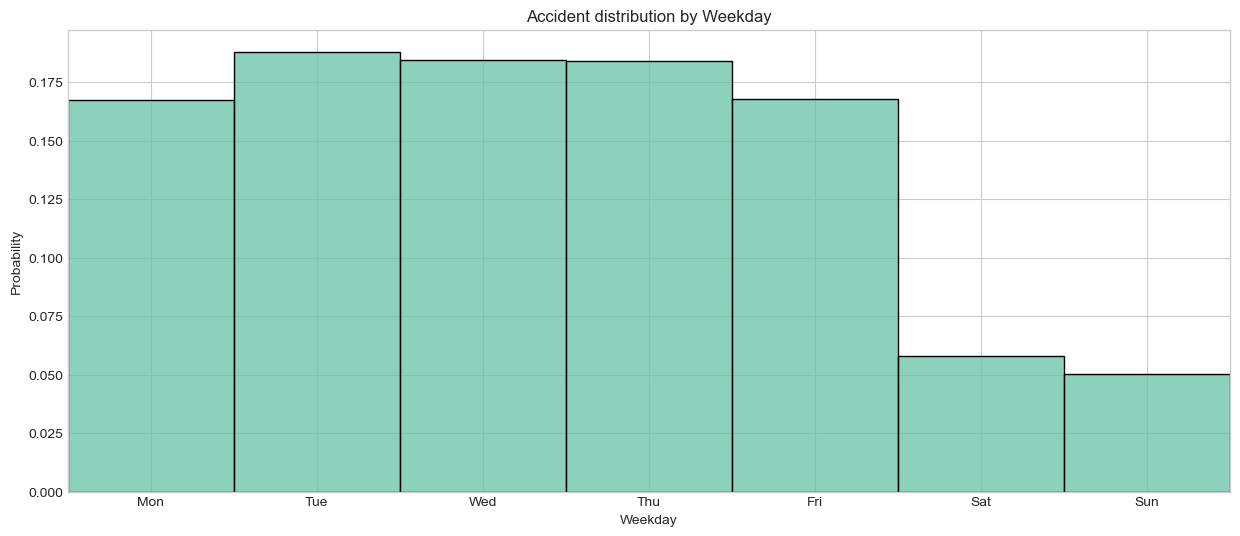

In [37]:
sns.histplot(df_clean['Start_Time'].dt.weekday, bins=7, stat='probability', discrete=True)
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlim(-0.5, 6.5)
plt.xlabel('Weekday')
plt.ylabel('Probability')
plt.title('Accident distribution by Weekday');

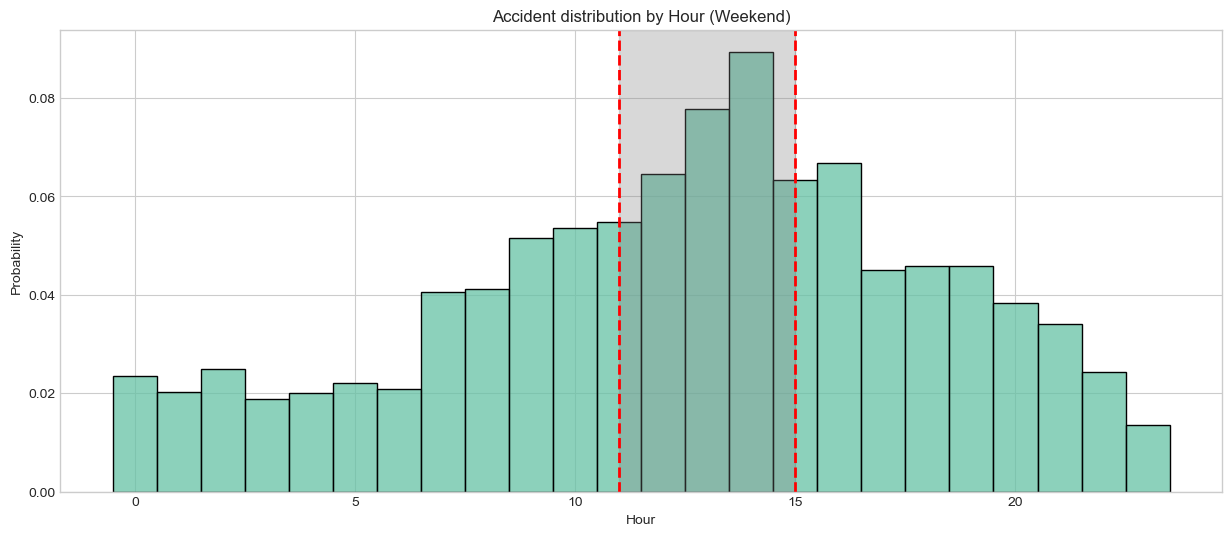

In [39]:
weekend = df_clean[df_clean['Start_Time'].dt.weekday.isin([5, 6])]
sns.histplot(weekend['Start_Time'].dt.hour, bins=24, discrete=True, stat='probability')
plt.axvline(x=11, color='red', linestyle='--', linewidth=2)
plt.axvline(x=15, color='red', linestyle='--', linewidth=2)
plt.axvspan(11, 15, color='gray', alpha=0.3)
plt.xlabel('Hour')
plt.ylabel('Probability')
plt.title('Accident distribution by Hour (Weekend)');

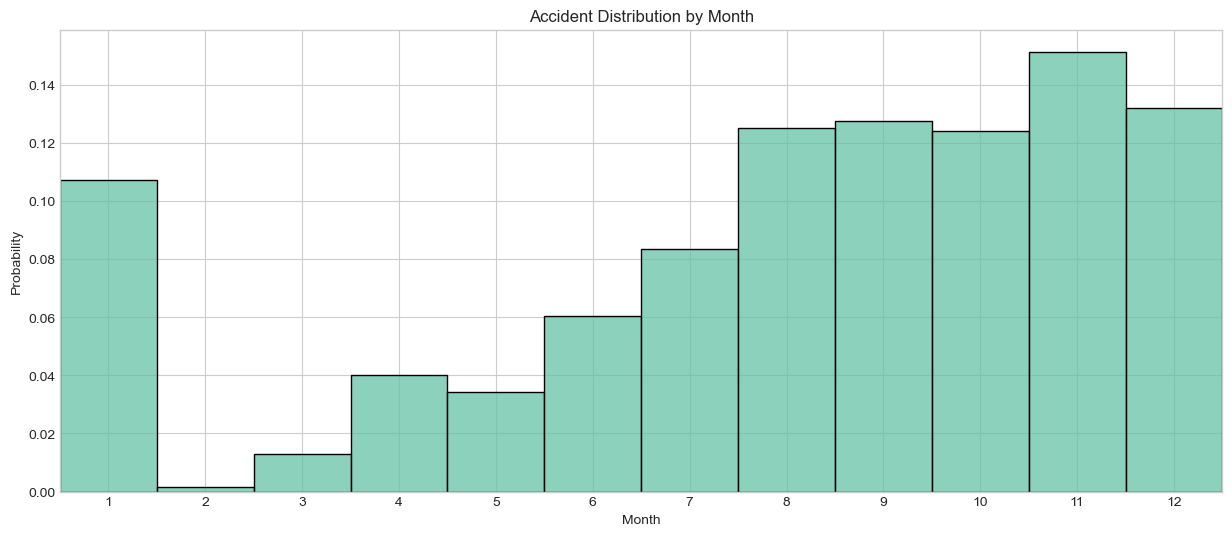

In [41]:
sns.histplot(df_clean['Start_Time'].dt.month, bins=12, stat='probability', discrete=True)
plt.xlim(0.5, 12.5)
plt.xticks(ticks=range(1, 13))
plt.xlabel('Month')
plt.ylabel('Probability')
plt.title('Accident Distribution by Month');

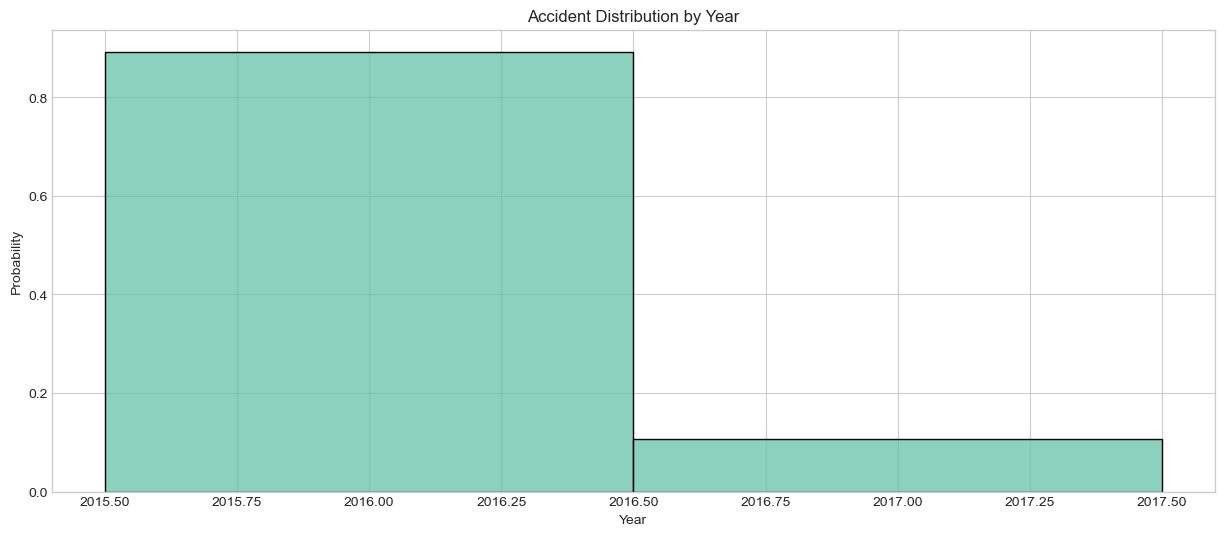

In [43]:
sns.histplot(df_clean['Start_Time'].dt.year, bins=12, stat='probability', discrete=True)
plt.xlabel('Year')
plt.ylabel('Probability')
plt.title('Accident Distribution by Year');

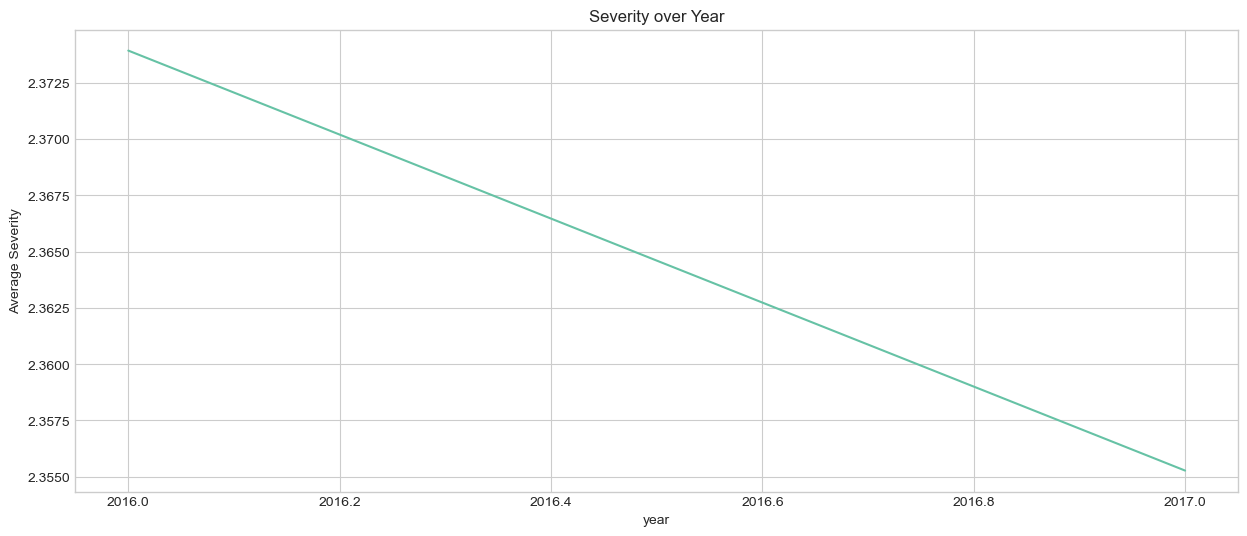

In [45]:
severity_over_year = df_clean.groupby(df_clean['Start_Time'].dt.year)['Severity'].mean()
severity_over_year.plot()
plt.title('Severity over Year')
plt.xlabel('year')
plt.ylabel('Average Severity');

In [47]:
print("="*80)
print("INGÉNIERIE DES FEATURES")
print("="*80)

# =====================================================
# 4.1 FEATURES TEMPORELLES
# =====================================================
print("\n📅 Création des features temporelles...")

df_clean['Start_Time'] = pd.to_datetime(df_clean['Start_Time'])

df_clean['hour'] = df_clean['Start_Time'].dt.hour
df_clean['day'] = df_clean['Start_Time'].dt.day
df_clean['month'] = df_clean['Start_Time'].dt.month
df_clean['year'] = df_clean['Start_Time'].dt.year
df_clean['dayofweek'] = df_clean['Start_Time'].dt.dayofweek
df_clean['is_weekend'] = (df_clean['dayofweek'] >= 5).astype(int)

print("   ✓ hour, day, month, year, dayofweek, is_weekend créés")


# =====================================================
# 4.2 DURÉE DE L'ACCIDENT
# =====================================================
print("\n⏱️ Calcul de la durée de l'accident...")

df_clean['End_Time'] = pd.to_datetime(df_clean['End_Time'], errors='coerce')
df_clean['duration_minutes'] = (df_clean['End_Time'] - df_clean['Start_Time']).dt.total_seconds() / 60

print(f"   ✓ Durée moyenne: {df_clean['duration_minutes'].mean():.2f} minutes")


# =====================================================
# 4.3 LUMINOSITÉ & CONDITIONS JOUR / NUIT
# =====================================================
print("\n🌅 Création des features de luminosité...")

df_clean['is_night'] = (df_clean['Sunrise_Sunset'] == 'Night').astype(int)
df_clean['is_day'] = (df_clean['Sunrise_Sunset'] == 'Day').astype(int)

print("   ✓ is_night, is_day créés")


# =====================================================
# 4.4 CONDITIONS MÉTÉO GROUPÉES
# =====================================================
print("\n🌦️ Simplification des conditions météo...")

def simplify_weather(x):
    if pd.isna(x):
        return 'Unknown'
    x = x.lower()
    if 'rain' in x or 'shower' in x:
        return 'Rain'
    if 'snow' in x:
        return 'Snow'
    if 'storm' in x or 'thunder' in x:
        return 'Storm'
    if 'fog' in x:
        return 'Fog'
    if 'cloud' in x:
        return 'Cloudy'
    if 'clear' in x:
        return 'Clear'
    return 'Other'

df_clean['Weather_Simple'] = df_clean['Weather_Condition'].apply(simplify_weather)

print("   ✓ Weather_Simple: Clear, Rain, Snow, Storm, Fog, Cloudy, Other")


# =====================================================
# 4.5 VISIBILITÉ CATEGORISÉE
# =====================================================
print("\n👁️ Catégorisation de la visibilité...")

df_clean['visibility_level'] = pd.cut(
    df_clean['Visibility(mi)'],
    bins=[0, 1, 3, 6, 10, float('inf')],
    labels=['très_faible', 'faible', 'moyenne', 'bonne', 'excellente']
)

print("   ✓ visibilité : très_faible → excellente")


# =====================================================
# 4.6 TYPE DE ROUTE À PARTIR DU 'Street'
# =====================================================
print("\n🛣️ Extraction du type de route...")

def get_road_type(street):
    if pd.isna(street):
        return 'Unknown'
    street = street.lower()
    if 'hwy' in street or 'highway' in street or 'route' in street or 'rt' in street:
        return 'Highway'
    if 'st' in street or 'street' in street or 'rd' in street or 'road' in street:
        return 'Road'
    if 'ave' in street or 'avenue' in street:
        return 'Avenue'
    if 'blvd' in street or 'boulevard' in street:
        return 'Boulevard'
    return 'Other'

df_clean['Road_Type'] = df_clean['Street'].apply(get_road_type)

print("   ✓ Road_Type: Highway, Road, Avenue, Boulevard, Other")


# =====================================================
# 4.7 HEURE — PÉRIODE DE LA JOURNÉE
# =====================================================
print("\n🕐 Définition de la période de la journée...")

def get_period(h):
    if 6 <= h < 12:
        return 'matin'
    elif 12 <= h < 18:
        return 'après-midi'
    elif 18 <= h < 22:
        return 'soirée'
    else:
        return 'nuit'

df_clean['day_period'] = df_clean['hour'].apply(get_period)

print("   ✓ day_period : matin / après-midi / soirée / nuit")

print(f"\n✅ Total features: {df_clean.shape[1]}")


INGÉNIERIE DES FEATURES

📅 Création des features temporelles...
   ✓ hour, day, month, year, dayofweek, is_weekend créés

⏱️ Calcul de la durée de l'accident...
   ✓ Durée moyenne: 41.62 minutes

🌅 Création des features de luminosité...
   ✓ is_night, is_day créés

🌦️ Simplification des conditions météo...
   ✓ Weather_Simple: Clear, Rain, Snow, Storm, Fog, Cloudy, Other

👁️ Catégorisation de la visibilité...
   ✓ visibilité : très_faible → excellente

🛣️ Extraction du type de route...
   ✓ Road_Type: Highway, Road, Avenue, Boulevard, Other

🕐 Définition de la période de la journée...
   ✓ day_period : matin / après-midi / soirée / nuit

✅ Total features: 55



📊 Visualisation des nouvelles features...


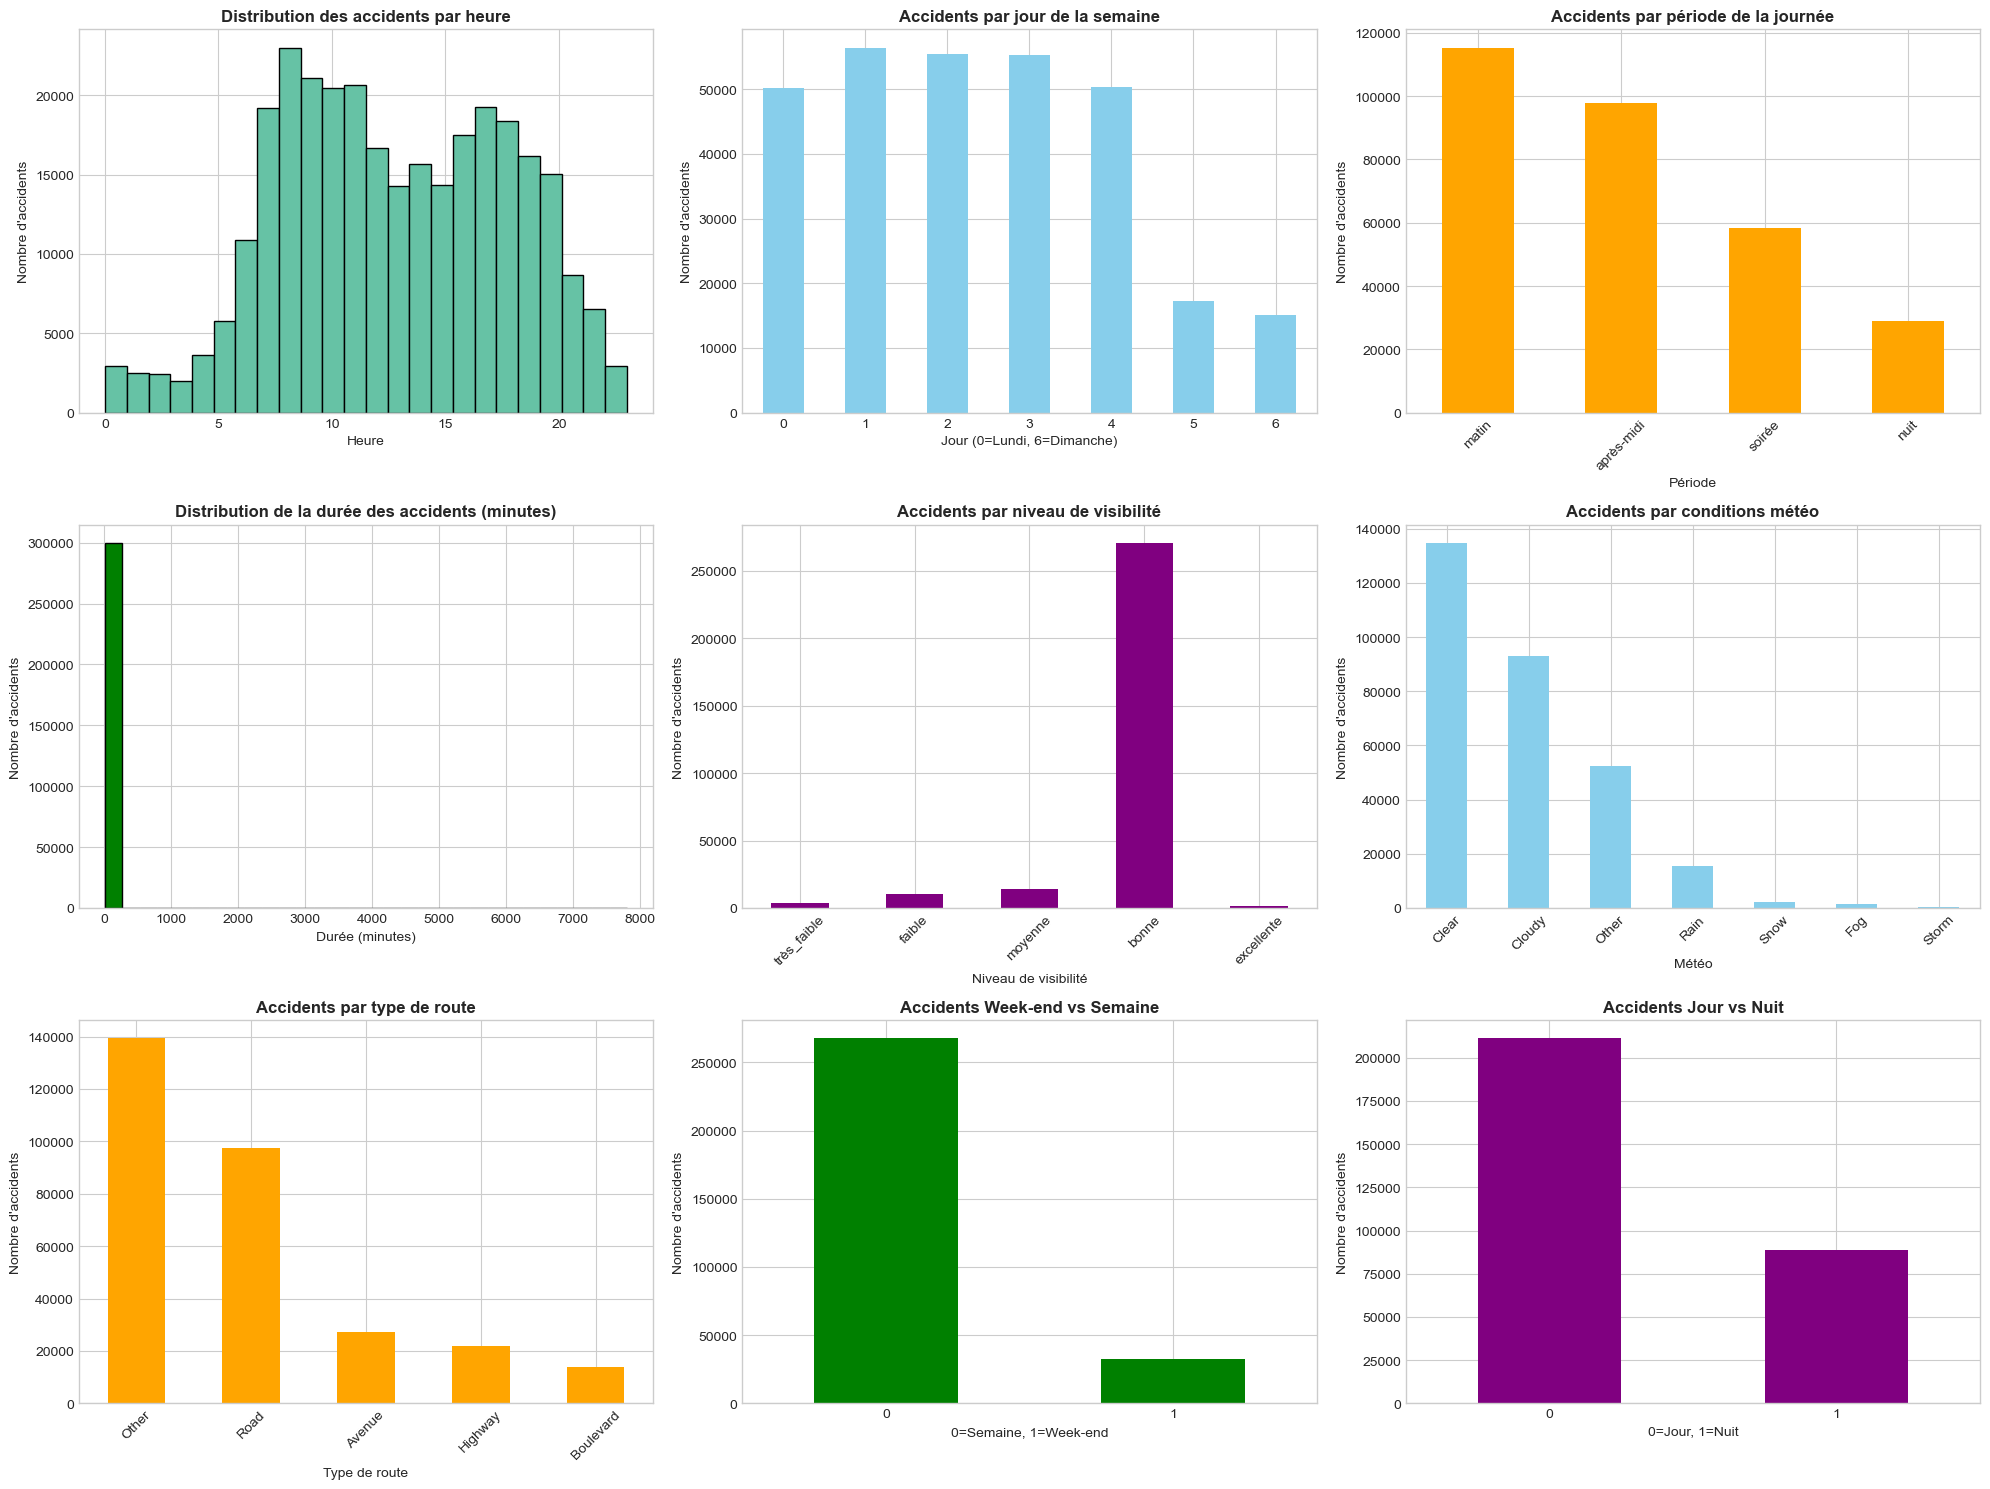

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n📊 Visualisation des nouvelles features...")

fig, axes = plt.subplots(3, 3, figsize=(20, 15))

# 1️⃣ Distribution par heure
df_clean['hour'].hist(ax=axes[0,0], bins=24, edgecolor='black')
axes[0,0].set_title('Distribution des accidents par heure', fontweight='bold')
axes[0,0].set_xlabel('Heure')
axes[0,0].set_ylabel('Nombre d\'accidents')

# 2️⃣ Distribution par jour de la semaine
df_clean['dayofweek'].value_counts().sort_index().plot(kind='bar', ax=axes[0,1], color='skyblue')
axes[0,1].set_title('Accidents par jour de la semaine', fontweight='bold')
axes[0,1].set_xlabel('Jour (0=Lundi, 6=Dimanche)')
axes[0,1].set_ylabel('Nombre d\'accidents')
axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=0)

# 3️⃣ Distribution par période de la journée
df_clean['day_period'].value_counts().plot(kind='bar', ax=axes[0,2], color='orange')
axes[0,2].set_title('Accidents par période de la journée', fontweight='bold')
axes[0,2].set_xlabel('Période')
axes[0,2].set_ylabel('Nombre d\'accidents')
axes[0,2].set_xticklabels(axes[0,2].get_xticklabels(), rotation=45)

# 4️⃣ Durée des accidents
df_clean['duration_minutes'].hist(ax=axes[1,0], bins=30, edgecolor='black', color='green')
axes[1,0].set_title('Distribution de la durée des accidents (minutes)', fontweight='bold')
axes[1,0].set_xlabel('Durée (minutes)')
axes[1,0].set_ylabel('Nombre d\'accidents')

# 5️⃣ Visibilité catégorisée
df_clean['visibility_level'].value_counts().sort_index().plot(kind='bar', ax=axes[1,1], color='purple')
axes[1,1].set_title('Accidents par niveau de visibilité', fontweight='bold')
axes[1,1].set_xlabel('Niveau de visibilité')
axes[1,1].set_ylabel('Nombre d\'accidents')
axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=45)

# 6️⃣ Conditions météo simplifiées
df_clean['Weather_Simple'].value_counts().plot(kind='bar', ax=axes[1,2], color='skyblue')
axes[1,2].set_title('Accidents par conditions météo', fontweight='bold')
axes[1,2].set_xlabel('Météo')
axes[1,2].set_ylabel('Nombre d\'accidents')
axes[1,2].set_xticklabels(axes[1,2].get_xticklabels(), rotation=45)

# 7️⃣ Road type
df_clean['Road_Type'].value_counts().plot(kind='bar', ax=axes[2,0], color='orange')
axes[2,0].set_title('Accidents par type de route', fontweight='bold')
axes[2,0].set_xlabel('Type de route')
axes[2,0].set_ylabel('Nombre d\'accidents')
axes[2,0].set_xticklabels(axes[2,0].get_xticklabels(), rotation=45)

# 8️⃣ Jour vs Week-end
df_clean['is_weekend'].value_counts().plot(kind='bar', ax=axes[2,1], color='green')
axes[2,1].set_title('Accidents Week-end vs Semaine', fontweight='bold')
axes[2,1].set_xlabel('0=Semaine, 1=Week-end')
axes[2,1].set_ylabel('Nombre d\'accidents')
axes[2,1].set_xticklabels(axes[2,1].get_xticklabels(), rotation=0)

# 9️⃣ Day/Night
df_clean['is_night'].value_counts().plot(kind='bar', ax=axes[2,2], color='purple')
axes[2,2].set_title('Accidents Jour vs Nuit', fontweight='bold')
axes[2,2].set_xlabel('0=Jour, 1=Nuit')
axes[2,2].set_ylabel('Nombre d\'accidents')
axes[2,2].set_xticklabels(axes[2,2].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

In [51]:
df_clean.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,hour,day,month,year,dayofweek,is_weekend,duration_minutes,is_night,is_day,Weather_Simple,visibility_level,Road_Type,day_period
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,I-70 E,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,91.0,29.68,10.0,Calm,8.1,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,5,8,2,2016,0,0,314.0,1,0,Rain,bonne,Other,nuit
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,Brice Rd,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,100.0,29.65,10.0,Calm,8.1,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day,6,8,2,2016,0,0,30.0,1,0,Rain,bonne,Road,matin
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,0.01,Accident on OH-32 State Route 32 Westbound at ...,State Route 32,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,100.0,29.67,10.0,SW,3.5,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day,6,8,2,2016,0,0,30.0,1,0,Other,bonne,Highway,matin
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,I-75 S,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,96.0,29.64,9.0,SW,4.6,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day,7,8,2,2016,0,0,30.0,1,0,Cloudy,bonne,Other,matin
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,Miamisburg Centerville Rd,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,89.0,29.65,6.0,SW,3.5,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day,7,8,2,2016,0,0,30.0,0,1,Cloudy,moyenne,Road,matin


In [53]:
df_clean.shape

(300000, 55)

Types de colonnes après encodage :
Source                     int32
Start_Lat                float64
Start_Lng                float64
Distance(mi)             float64
Street                     int32
City                       int32
County                     int32
State                      int32
Zipcode                    int32
Country                    int32
Timezone                   int32
Airport_Code               int32
Temperature(F)           float64
Humidity(%)              float64
Pressure(in)             float64
Visibility(mi)           float64
Wind_Direction             int32
Wind_Speed(mph)          float64
Weather_Condition          int32
Amenity                    int32
Bump                       int32
Crossing                   int32
Give_Way                   int32
Junction                   int32
No_Exit                    int32
Railway                    int32
Roundabout                 int32
Station                    int32
Stop                       int32
Traffic_

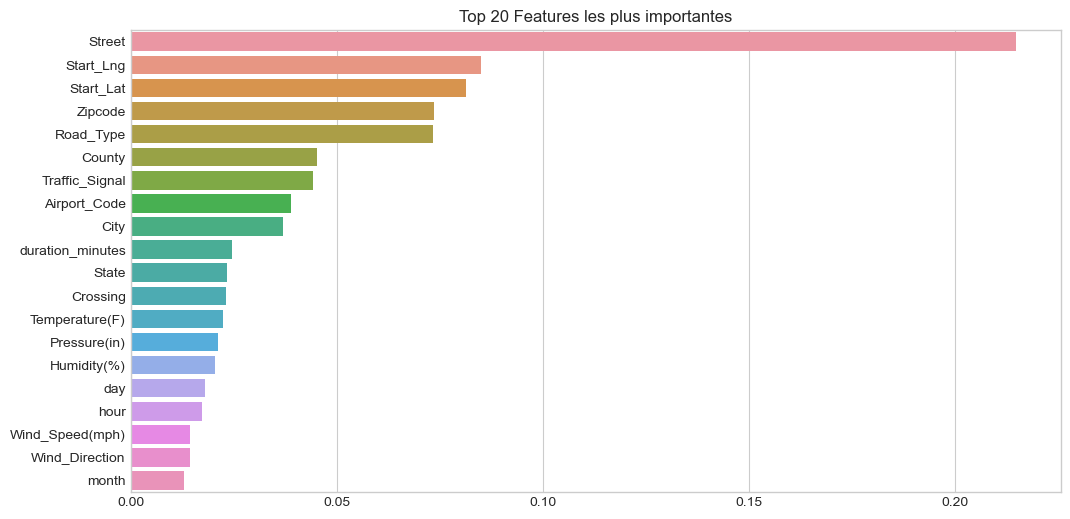

Top 20 features importantes : ['Street', 'Start_Lng', 'Start_Lat', 'Zipcode', 'Road_Type', 'County', 'Traffic_Signal', 'Airport_Code', 'City', 'duration_minutes', 'State', 'Crossing', 'Temperature(F)', 'Pressure(in)', 'Humidity(%)', 'day', 'hour', 'Wind_Speed(mph)', 'Wind_Direction', 'month']
Accuracy: 0.6449166666666667
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        42
           2       0.65      0.93      0.77     37661
           3       0.58      0.16      0.25     22261
           4       0.00      0.00      0.00        36

    accuracy                           0.64     60000
   macro avg       0.31      0.27      0.25     60000
weighted avg       0.63      0.64      0.57     60000



In [72]:
# 🔹 0️⃣ Import des librairies
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 1️⃣ Préparation des données

# Définir la cible
y = df_clean["Severity"]

# Colonnes à exclure (ID, textes, datetime)
cols_to_drop = ["Severity", "ID", "Start_Time", "End_Time", "Description", "Weather_Timestamp"]
X = df_clean.drop(columns=cols_to_drop)

# Identifier colonnes catégorielles (object, bool, category) et encoder
categorical_cols = X.select_dtypes(include=['object', 'bool', 'category']).columns
for col in categorical_cols:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Vérifier que toutes les colonnes sont numériques
print("Types de colonnes après encodage :")
print(X.dtypes)

# 🔹 2️⃣ Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔹 3️⃣ Sélection par Random Forest
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Importance des features
feat_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# 🔹 4️⃣ Affichage du top 20 features
plt.figure(figsize=(12,6))
sns.barplot(x=feat_importances.values[:20], y=feat_importances.index[:20])
plt.title("Top 20 Features les plus importantes")
plt.show()

# Liste des top features
top_features = feat_importances.index[:20].tolist()
print("Top 20 features importantes :", top_features)

# 🔹 5️⃣ Entraînement d’un modèle final (optionnel)
X_final = X[top_features]

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Features finales retenues : ['Start_Lng', 'Distance(mi)', 'Crossing', 'Timezone', 'Wind_Speed(mph)', 'County', 'City', 'day_period', 'Street', 'Start_Lat', 'State', 'duration_minutes', 'Traffic_Signal', 'is_weekend', 'Junction', 'Airport_Code', 'Weather_Condition', 'month', 'Road_Type', 'Wind_Direction', 'Weather_Simple']
Balanced Accuracy: 0.9538812986457401
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     37735
           1       0.91      0.93      0.92     37326
           2       0.92      0.89      0.91     37832
           3       0.99      1.00      0.99     37615

    accuracy                           0.95    150508
   macro avg       0.95      0.95      0.95    150508
weighted avg       0.95      0.95      0.95    150508



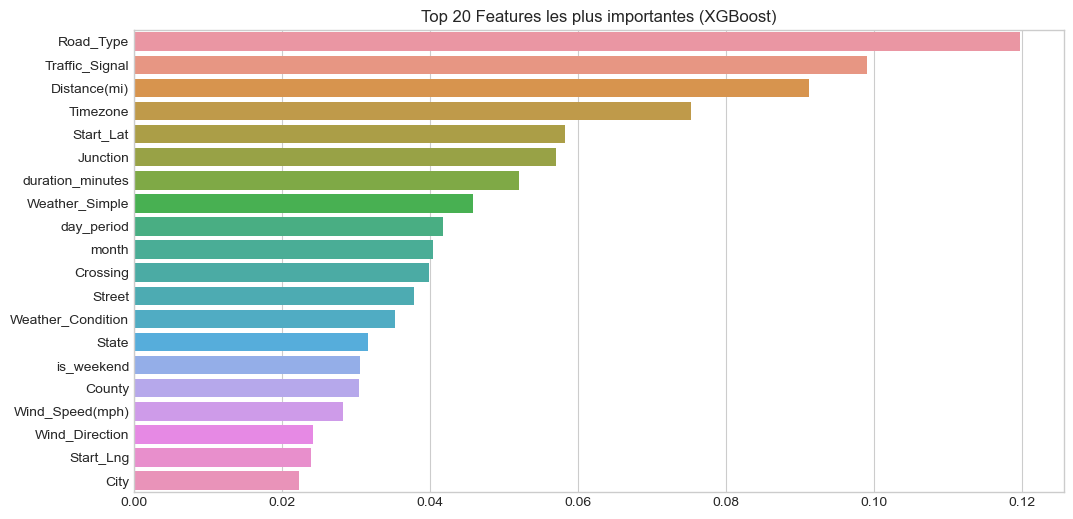

In [76]:
# 🔹 0️⃣ Import des librairies
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 1️⃣ Préparation des données
y = df_clean["Severity"]
cols_to_drop = ["Severity", "ID", "Start_Time", "End_Time", "Description", "Weather_Timestamp"]
X = df_clean.drop(columns=cols_to_drop)

# Encoder les colonnes catégorielles
categorical_cols = X.select_dtypes(include=['object', 'bool', 'category']).columns
for col in categorical_cols:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔹 2️⃣ Gérer le déséquilibre des classes avec SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

# 🔹 3️⃣ Sélection des features

# 3a) SelectKBest (statistique ANOVA)
skb = SelectKBest(score_func=f_classif, k=30)
X_skb = skb.fit_transform(X_res, y_res)
features_skb = X.columns[skb.get_support()]

# 3b) LASSO
lasso = Lasso(alpha=0.01, random_state=42)
lasso.fit(X_res, y_res)
features_lasso = X.columns[lasso.coef_ != 0]

# 3c) Random Forest Feature Importance
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_res, y_res)
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
features_rf = feat_importances.sort_values(ascending=False).head(30).index

# 🔹 Intersection finale des features
final_features = list(set(features_skb) & set(features_lasso) & set(features_rf))
print("Features finales retenues :", final_features)

X_final = pd.DataFrame(X_res, columns=X.columns)[final_features]

# 🔹 4️⃣ Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_final, y_res, test_size=0.2, random_state=42)

# 🔹 Décaler les classes pour XGBoost (0-indexed)
y_train = y_train - 1
y_test = y_test - 1

# 🔹 5️⃣ Entraînement du modèle XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# 🔹 6️⃣ Évaluation
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 🔹 7️⃣ Affichage des top features
importances = pd.Series(model.feature_importances_, index=X_final.columns).sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=importances.values[:20], y=importances.index[:20])
plt.title("Top 20 Features les plus importantes (XGBoost)")
plt.show()
